In [4]:
# Facial Emotion Classification using FER2013 Dataset
# This notebook implements facial emotion recognition using CNNs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.20.0


In [7]:
# ========================
# 1. DATA LOADING
# ========================

def load_data_from_folders(train_dir, test_dir, img_size=(48, 48), batch_size=64):
    """
    Load images from train/test folder structure.
    train_dir = "train/"
    test_dir = "test/"
    """

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1,
        shear_range=0.1,
        validation_split=0.2  # 20% of train data for validation
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    # Training generator
    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='sparse',
        subset='training'
    )

    # Validation generator
    val_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='sparse',
        subset='validation'
    )

    # Test generator
    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False
    )

    # Get emotion label mapping
    emotion_labels = {v: k for k, v in train_gen.class_indices.items()}
    print("Emotion Labels Mapping:", emotion_labels)

    return train_gen, val_gen, test_gen, emotion_labels

In [8]:
# ========================
# 2. MODEL ARCHITECTURE
# ========================

def create_emotion_cnn(input_shape=(48, 48, 1), num_classes=7):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [9]:
# ========================
# 3. TRAINING
# ========================

def train_model(model, train_gen, val_gen, epochs=50):
    cb_list = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
        callbacks.ModelCheckpoint('best_emotion_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=cb_list,
        verbose=1
    )
    return history

In [10]:
# ========================
# 4. PLOT HISTORY
# ========================

def plot_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()

In [11]:
# ========================
# 5. EVALUATION
# ========================

def evaluate_model(model, test_gen, emotion_labels):
    predictions = model.predict(test_gen)
    predicted_classes = np.argmax(predictions, axis=1)

    acc = np.mean(predicted_classes == test_gen.classes)
    print(f"Test Accuracy: {acc:.4f} ({acc*100:.2f}%)")

    print("\nClassification Report:")
    print(classification_report(test_gen.classes, predicted_classes, target_names=list(test_gen.class_indices.keys())))

    cm = confusion_matrix(test_gen.classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_gen.class_indices.keys(),
                yticklabels=test_gen.class_indices.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Loading data...
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Emotion Labels Mapping: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 44, 44, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 20, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 685,159 (2.61 MB)

 Trainable params: 683,687 (2.61 MB)

 Non-trainable params: 1,472 (5.75 KB)

Training model...
Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1869 - loss: 3.0098
Epoch 1: val_accuracy improved from None to 0.25135, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 715s 2s/step - accuracy: 0.1898 - loss: 2.8920 - val_accuracy: 0.2513 - val_loss: 1.8896 - learning_rate: 1.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.1966 - loss: 2.6548
Epoch 2: val_accuracy improved from 0.25135 to 0.25518, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 94s 262ms/step - accuracy: 0.1965 - loss: 2.5865 - val_accuracy: 0.2552 - val_loss: 1.8265 - learning_rate: 1.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.2011 - loss: 2.4128
Epoch 3: val_accuracy improved from 0.25518 to 0.26215, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 89s 246ms/step - accuracy: 0.2052 - loss: 2.3643 - val_accuracy: 0.2621 - val_loss: 1.7953 - learning_rate: 1.0000e-04
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.2054 - loss: 2.2560
Epoch 4: val_accuracy did not improve from 0.26215
359/359 ━━━━━━━━━━━━━━━━━━━━ 95s 265ms/step - accuracy: 0.2065 - loss: 2.2239 - val_accuracy: 0.2608 - val_loss: 1.7791 - learning_rate: 1.0000e-04
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.2124 - loss: 2.1412
Epoch 5: val_accuracy did not improve from 0.26215
359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 251ms/step - accuracy: 0.2120 - loss: 2.1165 - val_accuracy: 0.2590 - val_loss: 1.7809 - learning_rate: 1.0000e-04
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.2120 - loss: 2.0717
Epoch 6: val_accuracy did not improve from 0.26215
359/359 ━━━━━━━━━━━━━━━━━━━━ 91s 254ms/step - accuracy: 0.2141 - loss: 2.0512 - val_accuracy: 0.2609 - val_loss: 1.7885 - learning_rate: 1.

359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 250ms/step - accuracy: 0.2236 - loss: 1.9375 - val_accuracy: 0.2630 - val_loss: 1.7825 - learning_rate: 1.0000e-04
Epoch 9/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.2273 - loss: 1.9172
Epoch 9: val_accuracy improved from 0.26302 to 0.26424, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 93s 258ms/step - accuracy: 0.2266 - loss: 1.9120 - val_accuracy: 0.2642 - val_loss: 1.7784 - learning_rate: 1.0000e-04
Epoch 10/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.2277 - loss: 1.8768
Epoch 10: val_accuracy improved from 0.26424 to 0.26668, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 91s 253ms/step - accuracy: 0.2314 - loss: 1.8718 - val_accuracy: 0.2667 - val_loss: 1.7770 - learning_rate: 1.0000e-04
Epoch 11/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.2358 - loss: 1.8558
Epoch 11: val_accuracy improved from 0.26668 to 0.27399, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 251ms/step - accuracy: 0.2447 - loss: 1.8408 - val_accuracy: 0.2740 - val_loss: 1.7671 - learning_rate: 1.0000e-04
Epoch 12/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.2507 - loss: 1.8214
Epoch 12: val_accuracy improved from 0.27399 to 0.28061, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 89s 249ms/step - accuracy: 0.2583 - loss: 1.8147 - val_accuracy: 0.2806 - val_loss: 1.7537 - learning_rate: 1.0000e-04
Epoch 13/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.2695 - loss: 1.8028
Epoch 13: val_accuracy improved from 0.28061 to 0.28445, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 91s 252ms/step - accuracy: 0.2716 - loss: 1.7941 - val_accuracy: 0.2844 - val_loss: 1.7329 - learning_rate: 1.0000e-04
Epoch 14/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.2881 - loss: 1.7620
Epoch 14: val_accuracy did not improve from 0.28445
359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 250ms/step - accuracy: 0.2904 - loss: 1.7560 - val_accuracy: 0.2844 - val_loss: 1.7643 - learning_rate: 1.0000e-04
Epoch 15/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.2985 - loss: 1.7422
Epoch 15: val_accuracy improved from 0.28445 to 0.31423, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 251ms/step - accuracy: 0.3005 - loss: 1.7363 - val_accuracy: 0.3142 - val_loss: 1.6914 - learning_rate: 1.0000e-04
Epoch 16/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3054 - loss: 1.7249
Epoch 16: val_accuracy improved from 0.31423 to 0.32294, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 251ms/step - accuracy: 0.3118 - loss: 1.7152 - val_accuracy: 0.3229 - val_loss: 1.6742 - learning_rate: 1.0000e-04
Epoch 17/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3212 - loss: 1.6967
Epoch 17: val_accuracy did not improve from 0.32294
359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 252ms/step - accuracy: 0.3225 - loss: 1.6932 - val_accuracy: 0.3228 - val_loss: 1.6883 - learning_rate: 1.0000e-04
Epoch 18/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.3370 - loss: 1.6679
Epoch 18: val_accuracy improved from 0.32294 to 0.36771, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 250ms/step - accuracy: 0.3351 - loss: 1.6668 - val_accuracy: 0.3677 - val_loss: 1.6201 - learning_rate: 1.0000e-04
Epoch 19/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3466 - loss: 1.6580
Epoch 19: val_accuracy did not improve from 0.36771
359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 251ms/step - accuracy: 0.3505 - loss: 1.6441 - val_accuracy: 0.3498 - val_loss: 1.6396 - learning_rate: 1.0000e-04
Epoch 20/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3546 - loss: 1.6276
Epoch 20: val_accuracy improved from 0.36771 to 0.39645, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 251ms/step - accuracy: 0.3612 - loss: 1.6183 - val_accuracy: 0.3964 - val_loss: 1.5625 - learning_rate: 1.0000e-04
Epoch 21/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3592 - loss: 1.6117
Epoch 21: val_accuracy improved from 0.39645 to 0.40968, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 252ms/step - accuracy: 0.3658 - loss: 1.5996 - val_accuracy: 0.4097 - val_loss: 1.5368 - learning_rate: 1.0000e-04
Epoch 22/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.3840 - loss: 1.5756
Epoch 22: val_accuracy did not improve from 0.40968
359/359 ━━━━━━━━━━━━━━━━━━━━ 89s 249ms/step - accuracy: 0.3843 - loss: 1.5699 - val_accuracy: 0.4076 - val_loss: 1.5422 - learning_rate: 1.0000e-04
Epoch 23/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3873 - loss: 1.5674
Epoch 23: val_accuracy improved from 0.40968 to 0.42675, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 251ms/step - accuracy: 0.3915 - loss: 1.5564 - val_accuracy: 0.4268 - val_loss: 1.4936 - learning_rate: 1.0000e-04
Epoch 24/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.3943 - loss: 1.5528
Epoch 24: val_accuracy did not improve from 0.42675
359/359 ━━━━━━━━━━━━━━━━━━━━ 91s 253ms/step - accuracy: 0.3941 - loss: 1.5472 - val_accuracy: 0.4231 - val_loss: 1.4948 - learning_rate: 1.0000e-04
Epoch 25/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.4071 - loss: 1.5229
Epoch 25: val_accuracy did not improve from 0.42675
359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 250ms/step - accuracy: 0.4106 - loss: 1.5159 - val_accuracy: 0.4233 - val_loss: 1.5128 - learning_rate: 1.0000e-04
Epoch 26/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.4125 - loss: 1.5125
Epoch 26: val_accuracy improved from 0.42675 to 0.44713, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 91s 252ms/step - accuracy: 0.4183 - loss: 1.5002 - val_accuracy: 0.4471 - val_loss: 1.4463 - learning_rate: 1.0000e-04
Epoch 27/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.4207 - loss: 1.4958
Epoch 27: val_accuracy improved from 0.44713 to 0.45114, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 252ms/step - accuracy: 0.4213 - loss: 1.4885 - val_accuracy: 0.4511 - val_loss: 1.4352 - learning_rate: 1.0000e-04
Epoch 28/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.4342 - loss: 1.4595
Epoch 28: val_accuracy did not improve from 0.45114
359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 250ms/step - accuracy: 0.4365 - loss: 1.4593 - val_accuracy: 0.4457 - val_loss: 1.4543 - learning_rate: 1.0000e-04
Epoch 29/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.4335 - loss: 1.4658
Epoch 29: val_accuracy improved from 0.45114 to 0.46525, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 251ms/step - accuracy: 0.4414 - loss: 1.4495 - val_accuracy: 0.4652 - val_loss: 1.3858 - learning_rate: 1.0000e-04
Epoch 30/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.4464 - loss: 1.4350
Epoch 30: val_accuracy improved from 0.46525 to 0.47013, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 250ms/step - accuracy: 0.4476 - loss: 1.4325 - val_accuracy: 0.4701 - val_loss: 1.3735 - learning_rate: 1.0000e-04
Epoch 31/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.4572 - loss: 1.4226
Epoch 31: val_accuracy improved from 0.47013 to 0.47396, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 251ms/step - accuracy: 0.4591 - loss: 1.4156 - val_accuracy: 0.4740 - val_loss: 1.3670 - learning_rate: 1.0000e-04
Epoch 32/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.4555 - loss: 1.4147
Epoch 32: val_accuracy improved from 0.47396 to 0.49347, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 89s 249ms/step - accuracy: 0.4594 - loss: 1.4072 - val_accuracy: 0.4935 - val_loss: 1.3243 - learning_rate: 1.0000e-04
Epoch 33/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.4664 - loss: 1.4026
Epoch 33: val_accuracy did not improve from 0.49347
359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 252ms/step - accuracy: 0.4685 - loss: 1.3934 - val_accuracy: 0.4931 - val_loss: 1.3201 - learning_rate: 1.0000e-04
Epoch 34/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.4758 - loss: 1.3740
Epoch 34: val_accuracy did not improve from 0.49347
359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 250ms/step - accuracy: 0.4734 - loss: 1.3750 - val_accuracy: 0.4841 - val_loss: 1.3603 - learning_rate: 1.0000e-04
Epoch 35/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.4800 - loss: 1.3643
Epoch 35: val_accuracy improved from 0.49347 to 0.49817, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 252ms/step - accuracy: 0.4766 - loss: 1.3636 - val_accuracy: 0.4982 - val_loss: 1.3117 - learning_rate: 1.0000e-04
Epoch 36/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.4809 - loss: 1.3593
Epoch 36: val_accuracy did not improve from 0.49817
359/359 ━━━━━━━━━━━━━━━━━━━━ 98s 273ms/step - accuracy: 0.4839 - loss: 1.3536 - val_accuracy: 0.4971 - val_loss: 1.3147 - learning_rate: 1.0000e-04
Epoch 37/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.4915 - loss: 1.3459
Epoch 37: val_accuracy improved from 0.49817 to 0.50514, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 104s 290ms/step - accuracy: 0.4905 - loss: 1.3419 - val_accuracy: 0.5051 - val_loss: 1.2927 - learning_rate: 1.0000e-04
Epoch 38/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.4897 - loss: 1.3391
Epoch 38: val_accuracy improved from 0.50514 to 0.50967, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 120s 333ms/step - accuracy: 0.4915 - loss: 1.3336 - val_accuracy: 0.5097 - val_loss: 1.2739 - learning_rate: 1.0000e-04
Epoch 39/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4910 - loss: 1.3257
Epoch 39: val_accuracy improved from 0.50967 to 0.51454, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 121s 338ms/step - accuracy: 0.4954 - loss: 1.3246 - val_accuracy: 0.5145 - val_loss: 1.2767 - learning_rate: 1.0000e-04
Epoch 40/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.5022 - loss: 1.3093
Epoch 40: val_accuracy improved from 0.51454 to 0.51855, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 127s 354ms/step - accuracy: 0.5014 - loss: 1.3177 - val_accuracy: 0.5186 - val_loss: 1.2681 - learning_rate: 1.0000e-04
Epoch 41/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5011 - loss: 1.3145
Epoch 41: val_accuracy improved from 0.51855 to 0.52674, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 115s 319ms/step - accuracy: 0.5028 - loss: 1.3116 - val_accuracy: 0.5267 - val_loss: 1.2423 - learning_rate: 1.0000e-04
Epoch 42/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.5051 - loss: 1.3126
Epoch 42: val_accuracy did not improve from 0.52674
359/359 ━━━━━━━━━━━━━━━━━━━━ 114s 317ms/step - accuracy: 0.5061 - loss: 1.3044 - val_accuracy: 0.5262 - val_loss: 1.2509 - learning_rate: 1.0000e-04
Epoch 43/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5077 - loss: 1.2940
Epoch 43: val_accuracy did not improve from 0.52674
359/359 ━━━━━━━━━━━━━━━━━━━━ 113s 314ms/step - accuracy: 0.5097 - loss: 1.2925 - val_accuracy: 0.5267 - val_loss: 1.2400 - learning_rate: 1.0000e-04
Epoch 44/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.5085 - loss: 1.2835
Epoch 44: val_accuracy improved from 0.52674 to 0.53771, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 114s 319ms/step - accuracy: 0.5122 - loss: 1.2865 - val_accuracy: 0.5377 - val_loss: 1.2186 - learning_rate: 1.0000e-04
Epoch 45/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5163 - loss: 1.2644
Epoch 45: val_accuracy did not improve from 0.53771
359/359 ━━━━━━━━━━━━━━━━━━━━ 113s 313ms/step - accuracy: 0.5154 - loss: 1.2755 - val_accuracy: 0.5320 - val_loss: 1.2139 - learning_rate: 1.0000e-04
Epoch 46/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5150 - loss: 1.2719
Epoch 46: val_accuracy did not improve from 0.53771
359/359 ━━━━━━━━━━━━━━━━━━━━ 113s 315ms/step - accuracy: 0.5169 - loss: 1.2746 - val_accuracy: 0.5341 - val_loss: 1.2240 - learning_rate: 1.0000e-04
Epoch 47/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5217 - loss: 1.2626
Epoch 47: val_accuracy did not improve from 0.53771
359/359 ━━━━━━━━━━━━━━━━━━━━ 114s 316ms/step - accuracy: 0.5198 - loss: 1.2640 - val_accuracy: 0.5374 - val_loss: 1.2201 - learnin

359/359 ━━━━━━━━━━━━━━━━━━━━ 113s 314ms/step - accuracy: 0.5226 - loss: 1.2570 - val_accuracy: 0.5419 - val_loss: 1.2107 - learning_rate: 1.0000e-04
Epoch 49/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.5275 - loss: 1.2480
Epoch 49: val_accuracy did not improve from 0.54189
359/359 ━━━━━━━━━━━━━━━━━━━━ 113s 316ms/step - accuracy: 0.5238 - loss: 1.2505 - val_accuracy: 0.5356 - val_loss: 1.2030 - learning_rate: 1.0000e-04
Epoch 50/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5287 - loss: 1.2423
Epoch 50: val_accuracy improved from 0.54189 to 0.54329, saving model to best_emotion_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 113s 315ms/step - accuracy: 0.5293 - loss: 1.2449 - val_accuracy: 0.5433 - val_loss: 1.1960 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 50.
Plotting training history...


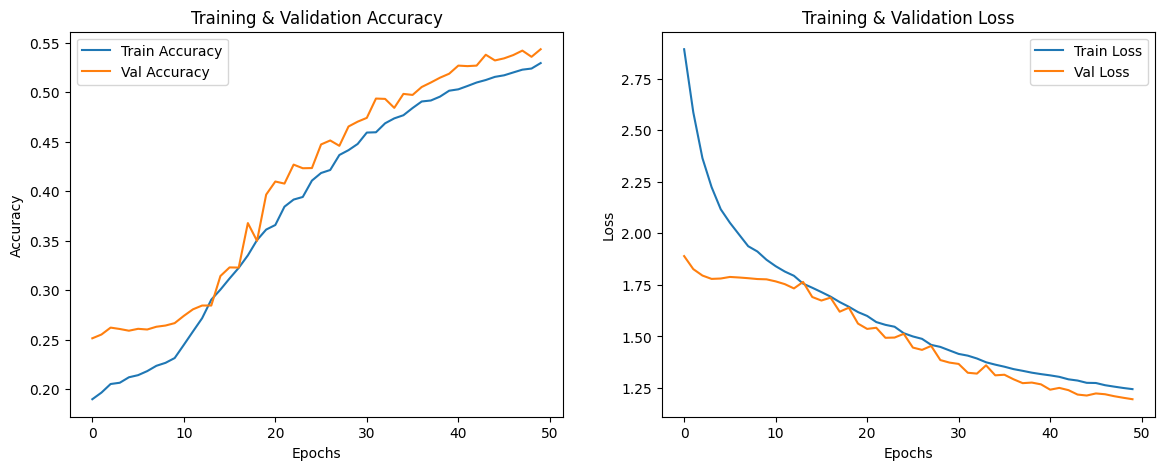

Evaluating model...
113/113 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step
Test Accuracy: 0.5600 (56.00%)

Classification Report:
              precision    recall  f1-score   support

       angry       0.45      0.45      0.45       958
     disgust       0.46      0.05      0.10       111
        fear       0.38      0.08      0.13      1024
       happy       0.77      0.84      0.80      1774
     neutral       0.45      0.70      0.55      1233
         sad       0.45      0.41      0.43      1247
    surprise       0.64      0.77      0.70       831

    accuracy                           0.56      7178
   macro avg       0.51      0.47      0.45      7178
weighted avg       0.54      0.56      0.53      7178



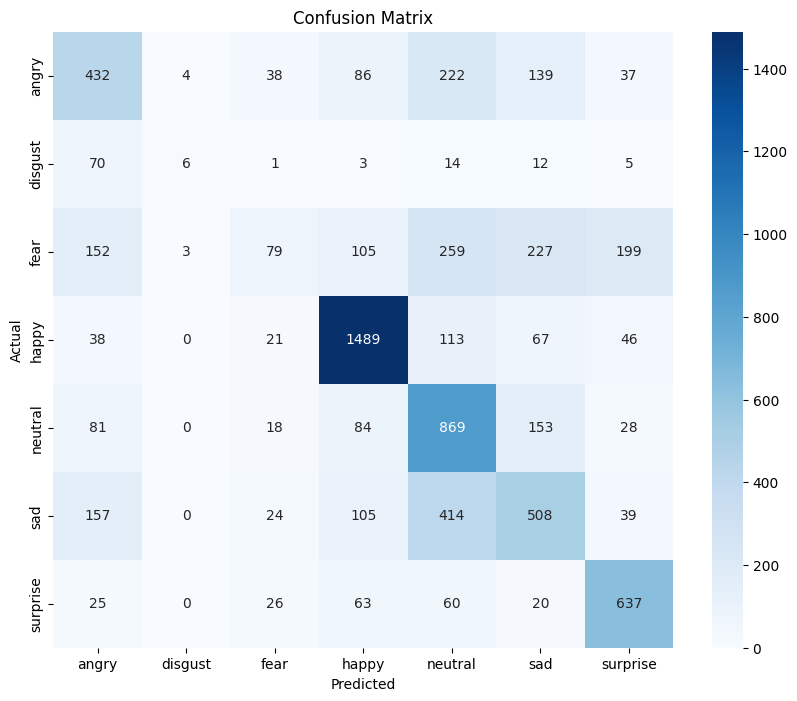

Model saved as final_emotion_model.h5


In [12]:
# ========================
# 6. MAIN EXECUTION
# ========================

def main():
    train_dir = "train"  # <-- your train folder
    test_dir = "test"    # <-- your test folder

    print("Loading data...")
    train_gen, val_gen, test_gen, emotion_labels = load_data_from_folders(train_dir, test_dir)

    print("Building model...")
    model = create_emotion_cnn(input_shape=(48, 48, 1), num_classes=len(emotion_labels))
    model.summary()

    print("Training model...")
    history = train_model(model, train_gen, val_gen, epochs=50)

    print("Plotting training history...")
    plot_history(history)

    print("Evaluating model...")
    evaluate_model(model, test_gen, emotion_labels)

    model.save("final_emotion_model.h5")
    print("Model saved as final_emotion_model.h5")


if __name__ == "__main__":
    main()